In [1]:
import numpy as np
from numpy import random
import math
from matplotlib import pyplot as plt
from scipy import misc
import scipy
from tqdm import tqdm, trange
from time import perf_counter

from sklearn.utils.extmath import randomized_svd as _sklearn_rsvd

In [2]:
%cd ..
from rputil import *
%cd -

/mnt/c/Users/rishi/GitHub/icerm/random-projections
/mnt/c/Users/rishi/GitHub/icerm/random-projections/notebooks


## Define low-rank approximation methods

In [3]:
import scipy.linalg.interpolative as sli

def scipy_id(A, k):
    idx, proj = sli.interp_decomp(A, k, rand=False)
    B = sli.reconstruct_skel_matrix(A, k, idx)
    C = sli.reconstruct_matrix_from_id(B, idx, proj)
    return C

def scipy_rid(A, k):
    idx, proj = sli.interp_decomp(A, k, rand=True)
    B = sli.reconstruct_skel_matrix(A, k, idx)
    C = sli.reconstruct_matrix_from_id(B, idx, proj)
    return C

In [4]:
def ropid(A, k, choices=None):
    cols = choices
    if choices is None:
        cols = np.random.choice(A.shape[1], replace=False, size=k)
    AS = A[:,cols]
    Q, R = scipy.linalg.qr(AS, pivoting=False, mode='economic')
    return Q @ Q.T @ A

In [5]:
# def normalrandomprojid(A, k):
#     Omega = np.random.randn(A.shape[1], k) #(n,k)
#     Y = A @ Omega # (m,k)
#     Q, R, P = scipy.linalg.qr(Y, mode='economic', pivoting=True)
#     return Q @ (Q.T @ A) # parentheses are necessary for optimal performance

In [6]:
# def sklearn_rsvd(A, k):
#     U,sigma,Vh = _sklearn_rsvd(A, k, random_state=None)
#     return U @ np.diag(sigma) @ Vh

## Read data

In [7]:
import pandas as pd
mnist = pd.read_csv('../datasets/mnist/train.csv')

data = mnist[mnist.columns[1:]].values / 255
data = data[:5000]

Transpose the data matrix if necessary --- we want the matrix to be 'wide' not 'tall'.

In [8]:
if data.shape[0] > data.shape[1]:
    data = data.T

In [9]:
def display_img(A, n):
    choices = np.random.choice(A.shape[1], replace=False, size=n)
    plt.imshow(A[:,choices].reshape(28,28,n).transpose(0,2,1).reshape(28,n*28))

In [10]:
# array.shape = (a,b,c)
# np.transpose(array, (2,0,1)) = (c,a,b)

In [11]:
# display_img(data, 5)

In [12]:
data_norm = np.linalg.norm(data)

In [13]:
def calculate_error(A):
    return np.linalg.norm(data - A) / data_norm

In [14]:
def stats(A):
    res = np.empty(7)
    
    res[0] = np.quantile(A, 0.25)
    res[1] = np.median(A)
    res[2] = np.quantile(A, 0.75)
    res[3] = np.mean(A)
    res[4] = np.std(A)
    res[5] = np.min(A)
    res[6] = np.max(A)
    
    return np.copy(res)

In [15]:
k_domain = np.arange(10, 490, step=40)
k_len = k_domain.shape[0]

### deterministic methods

In [16]:
DET_ALGS = [svd_rank_k, id_rank_k, scipy_id]
num_det_algs = len(DET_ALGS)

DET_ERRORS = np.empty((num_det_algs, k_len))
DET_TIMES = np.empty((num_det_algs, k_len))

for i, k in enumerate(tqdm(k_domain)):
    for h, alg in enumerate(DET_ALGS):
        start = perf_counter()
        DET_ERRORS[h,i] = calculate_error(alg(data, k))
        DET_TIMES[h,i] = perf_counter() - start

100%|██████████| 12/12 [01:06<00:00,  5.56s/it]


### randomized methods

In [17]:
RAND_ALGS = [random_id_rank_k, scipy_rid]
num_rand_algs = len(RAND_ALGS)

RAND_ERRORS = np.empty((num_rand_algs, 7, k_len))
RAND_TIMES = np.empty((num_rand_algs, 7, k_len))

iterations = 3 #10

for i, k in enumerate(tqdm(k_domain)):
    errors = np.empty((num_rand_algs, iterations))
    times = np.empty((num_rand_algs, iterations))

    for j in range(iterations):
        for h, alg in enumerate(RAND_ALGS):
            start = perf_counter()
            errors[h,j] = calculate_error(alg(data,k))
            times[h,j] = perf_counter() - start
        
    for h in range(num_rand_algs):
        RAND_ERRORS[h,:,i] = stats(errors[h])
        RAND_TIMES[h,:,i] = stats(times[h])

100%|██████████| 12/12 [01:06<00:00,  5.57s/it]


## Display results

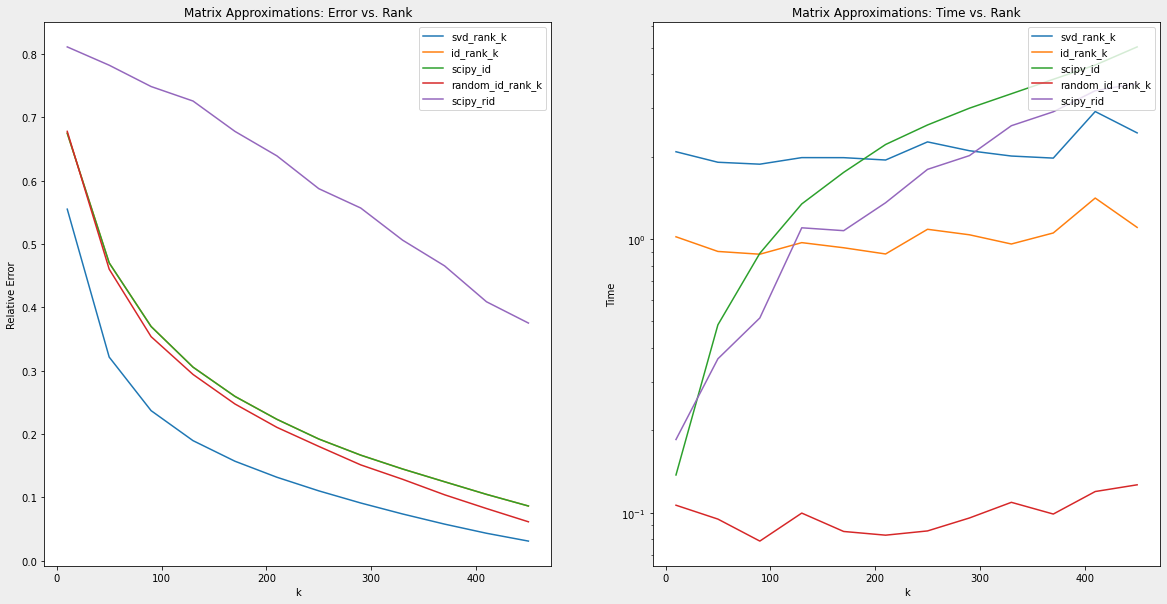

In [18]:
fig, ax = plt.subplots(1,2, figsize=(20,10))
fig.set_facecolor('#EEE')


# ERROR GRAPH
for h, alg in enumerate(DET_ALGS):
    ax[0].plot(k_domain, DET_ERRORS[h], label=alg.__name__)
for h, alg in enumerate(RAND_ALGS):
    ax[0].plot(k_domain, RAND_ERRORS[h,3], label=alg.__name__)
ax[0].set_xlabel('k')
ax[0].set_ylabel('Relative Error')
# ax[0].set_yscale('log')
ax[0].legend(loc='upper right')
ax[0].set_title('Matrix Approximations: Error vs. Rank')


# TIME GRAPH
for h, alg in enumerate(DET_ALGS):
    ax[1].plot(k_domain, DET_TIMES[h], label=alg.__name__)
for h, alg in enumerate(RAND_ALGS):
    ax[1].plot(k_domain, RAND_TIMES[h,3], label=alg.__name__)
ax[1].set_xlabel('k')
ax[1].set_ylabel('Time')
ax[1].set_yscale('log')
ax[1].legend(loc='upper right')
ax[1].set_title('Matrix Approximations: Time vs. Rank');

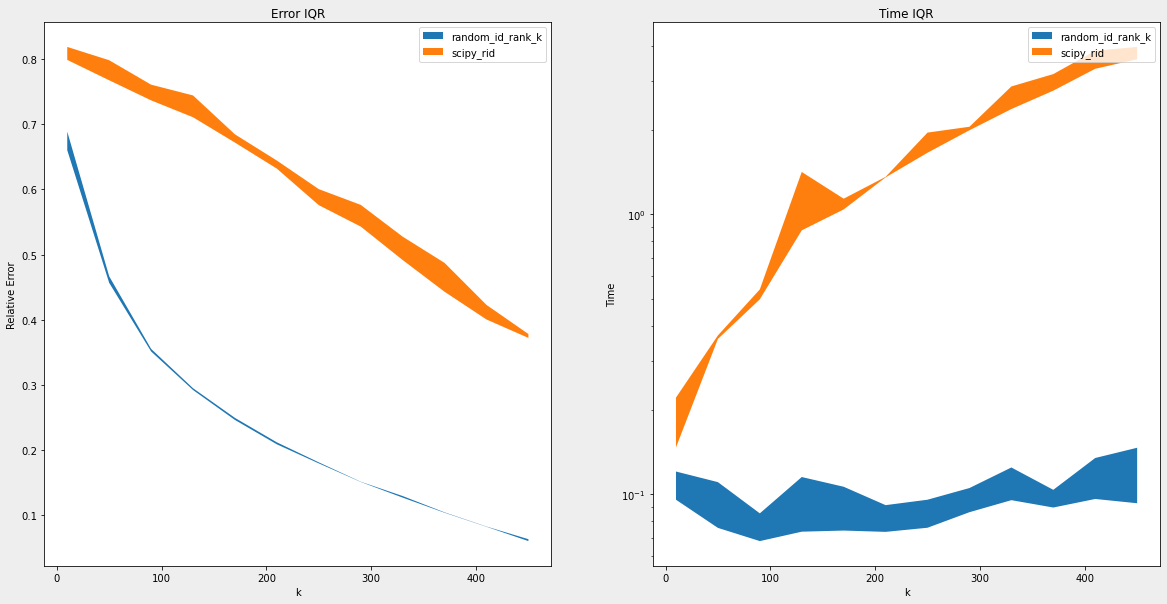

In [20]:
fig, ax = plt.subplots(1,2, figsize=(20,10))
fig.set_facecolor('#EEE')

for h, alg in enumerate(RAND_ALGS):
    ax[0].fill_between(k_domain, RAND_ERRORS[h,5], RAND_ERRORS[h,6], label=alg.__name__)

ax[0].set_xlabel('k')
ax[0].set_ylabel('Relative Error')
# ax[0].set_yscale('log')
ax[0].legend(loc='upper right')
ax[0].set_title('Error IQR')


for h, alg in enumerate(RAND_ALGS):
    ax[1].fill_between(k_domain, RAND_TIMES[h,5], RAND_TIMES[h,6], label=alg.__name__)

ax[1].set_xlabel('k')
ax[1].set_ylabel('Time')
ax[1].set_yscale('log')
ax[1].legend(loc='upper right')
ax[1].set_title('Time IQR');

### Test to see if low-rank approximation preserves $k$ columns.

In [21]:
temp_k = 200

In [22]:
func = ropid

In [23]:
cols = np.random.choice(data.shape[1], replace=False, size=temp_k)
approx = func(data, temp_k, choices=cols)

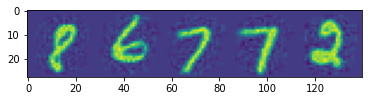

In [24]:
display_img(approx, 5)

In [25]:
eps = 0.00000001

print(f'{np.sum(approx > eps) / approx.size:.1%} of entries are greater than {eps}')

44.1% of entries are greater than 1e-08


In [26]:
print(f'The average value of an entry is {np.mean(approx):.4f}')

The average value of an entry is 0.1310


In [27]:
assert np.allclose(approx[:,cols], data[:,cols]), "This low-rank approximation was not formed from an ID."

In [28]:
np.linalg.matrix_rank(approx, tol=0.001)

200

In [29]:
np.linalg.matrix_rank(data, tol=0.001)

646

### Try to recreate the decomposition from the approximation.

In [30]:
C = approx[:,cols]

In [31]:
res = np.linalg.lstsq(C, approx, rcond=None)
Z = res[0]
print(f'Worst LS residual: {max(res[1])}')

Worst LS residual: 9.20642820792746e-29


In [32]:
np.allclose(C @ Z, approx)

True

In [33]:
np.max(np.abs(Z))

1.1007996696256717